In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# LOAD
file = 'df_master_1992-2017'
f = open(file,'rb') 
df = pickle.load(f) 
f.close()

In [3]:
df_match = df[df.match == 'match']

**Features to focus on:**  
* Budget
* Gross
* Genre (dummy variables)
* Country (US or UK - dummy variables)
* Runtime
* Metacritic score
* Total nominations
* Total wins
* Month

In [4]:
df = df_match[['imdb_name', 'imdb_year', 'budget', 'gross', 'drama', 'comedy', 'action', 'crime', 'romance', 
                 'sport', 'biography', 'mystery', 'musical', 'thriller', 'adventure',
                 'sci-fi', 'family', 'history', 'USA', 'UK', 'runtime', 'metacritic', 
                   'total_noms', 'total_wins', 'month', 'winner', 'nominee', 'bp_nominee', 'oscar_name', 'oscar_year']]

In [5]:
df.head()

,imdb_name,imdb_year,budget,gross,drama,comedy,action,crime,romance,sport,...,runtime,metacritic,total_noms,total_wins,month,winner,nominee,bp_nominee,oscar_name,oscar_year
0,Unforgiven,1992,"$14,400,000","$101,157,447",1,0,0,0,0,0,...,130 min,85,37,47,August,1.0,1.0,1.0,unforgiven,1993
1,The Crying Game,1992,"£2,300,000","$62,549,000",1,0,0,1,1,0,...,112 min,90,42,21,February,0.0,1.0,1.0,the crying game,1993
2,A Few Good Men,1992,"$40,000,000","$141,340,178",1,0,0,0,0,0,...,138 min,62,29,10,December,0.0,1.0,1.0,a few good men,1993
3,Howards End,1992,NaN,"$25,967,000",1,0,0,0,1,0,...,140 min,89,42,31,February,0.0,1.0,1.0,howards end,1993
4,Scent of a Woman,1992,"$31,000,000","$63,895,607",1,0,0,0,0,0,...,156 min,59,13,6,January,0.0,1.0,1.0,scent of a woman,1993


**Convert runtime, budget, gross into integers**

In [6]:
for i in ['budget', 'runtime', 'gross']:
    df[i] = df[i].replace(np.nan, '')

In [7]:
df['test'] = df.runtime.map(lambda x: re.findall(r'[0-9]+', x))
df['runtime'] = df.test.apply(lambda x: int(x[0]) if len(x)>0 else np.nan)

In [8]:
df['gross_new'] = df.gross.map(lambda x: ''.join(e for e in x if e.isdigit() or e == '.'))
df['gross_dollar'] = df.gross.apply(lambda x: 1 if '$' in x else 0)
df['gross_new'] = df.gross_new.map(lambda x: int(x) if len(x)>0 else np.nan)

In [9]:
df['budget_new'] = df.budget.map(lambda x: ''.join(e for e in x if e.isdigit() or e == '.'))
df['budget_dollar'] = df.budget.apply(lambda x: 1 if '$' in x else 0)

In [10]:
df['budget_currency'] = df.budget.map(lambda x: x[0] if len(x)>0 else '')
df.budget_currency.value_counts()

$    1000
      808
€      48
£      26
F      12
C      11
A       4
D       4
H       3
B       2
J       1
E       1
N       1
I       1
K       1
S       1
Name: budget_currency, dtype: int64

**NOTE**: Need to drop budget - too many missings

## Handle missing data

In [11]:
df.isnull().sum()

imdb_name            0
imdb_year            0
budget               0
gross                0
drama                0
comedy               0
action               0
crime                0
romance              0
sport                0
biography            0
mystery              0
musical              0
thriller             0
adventure            0
sci-fi               0
family               0
history              0
USA                  0
UK                   0
runtime            259
metacritic          57
total_noms         427
total_wins         336
month               12
winner             239
nominee              0
bp_nominee           0
oscar_name           0
oscar_year           0
test                 0
gross_new          177
gross_dollar         0
budget_new           0
budget_dollar        0
budget_currency      0
dtype: int64

In [12]:
# Replace with zero
for i in ['total_noms', 'total_wins', 'winner']:
    df.loc[df[i].isnull() , i] = 0

In [13]:
# Replace with mean
for i in ['metacritic', 'gross_new', 'runtime']:
    df[i].fillna(df[i].mean(), inplace = True)

# Create new variables

In [14]:
# Convert month to season and create dummies
seasons = {"season": {"January": 'Winter', "February": 'Spring', "March": 'Spring',
                     "April": 'Spring', "May": 'Spring', "June": 'Summer', "July": 'Summer', 
                     "August": 'Summer', "September": 'Summer', "October": 'Winter', 
                     "November": 'Winter', "December": 'Winter' }}

df['season'] = df.month
df.replace(seasons, inplace=True)

df_season = pd.get_dummies(df['season'])
df = pd.concat([df, df_season], axis=1)

In [15]:
# Standardize continuous variables by year
for i in ['gross_new', 'metacritic', 'total_wins', 'total_noms']:
    df[i + str('_norm')] = df.groupby('imdb_year')[i].transform(lambda x: (x - x.mean()) / x.std())

(array([ 1235.,   437.,   113.,    70.,    24.,    20.,    11.,     6.,
            4.,     2.]),
 array([-0.95276172, -0.10695448,  0.73885275,  1.58465999,  2.43046722,
         3.27627446,  4.1220817 ,  4.96788893,  5.81369617,  6.65950341,
         7.50531064]),
 <a list of 10 Patch objects>)

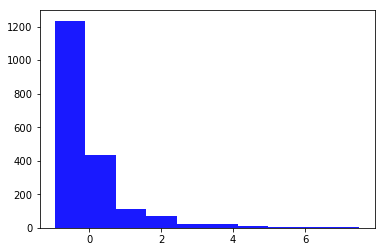

In [16]:
plt.hist(df.gross_new_norm.dropna(), alpha=0.9, color='blue')

In [17]:
# Log transform gross, wins, and noms
for i in ['gross_new_norm', 'total_wins_norm', 'total_noms_norm']:
    df['log_' + i] = df[i].map(lambda x: np.log(x + 1))

(array([  15.,    9.,   30.,  113.,  815.,  441.,  259.,  142.,   75.,   23.]),
 array([-3.05255072, -2.53322657, -2.01390242, -1.49457828, -0.97525413,
        -0.45592998,  0.06339416,  0.58271831,  1.10204246,  1.6213666 ,
         2.14069075]),
 <a list of 10 Patch objects>)

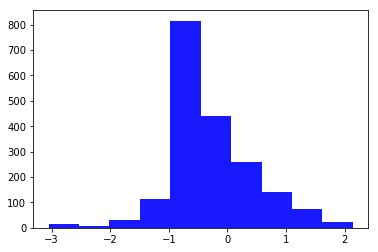

In [18]:
plt.hist(df.log_gross_new_norm.dropna(), alpha=0.9, color='blue')

(array([ 186.,  429.,  418.,  346.,  212.,  133.,   76.,   69.,   32.,   20.]),
 array([-1.37843673, -1.034832  , -0.69122727, -0.34762254, -0.00401781,
         0.33958692,  0.68319165,  1.02679638,  1.37040111,  1.71400584,
         2.05761057]),
 <a list of 10 Patch objects>)

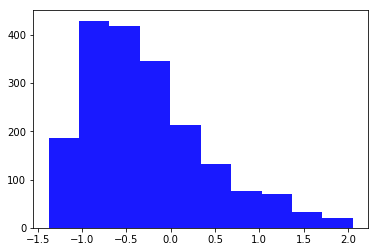

In [22]:
plt.hist(df.log_total_wins_norm.dropna(), alpha=0.9, color='blue')

(array([  13.,  191.,  277.,  356.,  329.,  246.,  214.,  141.,  102.,   52.]),
 array([-2.24598137, -1.84161168, -1.437242  , -1.03287232, -0.62850264,
        -0.22413295,  0.18023673,  0.58460641,  0.98897609,  1.39334578,
         1.79771546]),
 <a list of 10 Patch objects>)

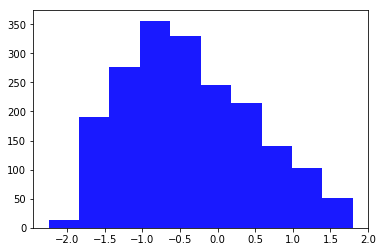

In [23]:
plt.hist(df.log_total_noms_norm.dropna(), alpha=0.9, color='blue')

## Export df to be used in model

In [19]:
df_model = df[['imdb_name', 'imdb_year', 'log_gross_new_norm',
               'drama', 'comedy', 'action', 'crime', 'romance', 'sport', 'biography', 'mystery', 'musical', 
               'thriller', 'adventure', 'sci-fi', 'family', 'history', 'USA', 'UK', 
               'runtime', 'metacritic_norm', 'log_total_noms_norm', 'log_total_wins_norm', 
               'winner', 'season', 'Winter', 'Summer', 'Spring', 'nominee', 'bp_nominee', 'oscar_name', 'oscar_year']]

In [20]:
# DUMP
file = 'df_master_1992-2017_cleaned'
fileobj = open(file,'wb') 
pickle.dump(df_model,fileobj)

In [21]:
df_model.to_csv('oscars_df_clean.csv', index=False, header=True)